# quantify degree of geostrophy with instantaneous fields

Xiaolong initial [notebook](https://github.com/xy6g13/equinox_working/blob/master/sandbox/Reconstruction/Geostrophy%20metric.ipynb)

In [1]:
import os, sys, shutil
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xgcm

from mitequinox.utils import *
from mitequinox.dynamic import *
from mitequinox.plot import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=1)
#w = cluster.scale(40)
w = cluster.scale(5) # postprocessing

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/bokeh/core.py:56: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.135.39.90:44590 Dashboard: http://10.135.39.90:41726/status,Cluster Workers: 5 Cores: 5 Memory: 200.00 GB


---
# load data


In [6]:
grd = load_grd().drop(['hFacC','hFacW','hFacS','rA','rAw','rAs'])

dsU = xr.open_zarr(work_data_dir+'rechunked/%s_std.zarr'%('SSU'))
dsV = xr.open_zarr(work_data_dir+'rechunked/%s_std.zarr'%('SSV'))
dsE = xr.open_zarr(work_data_dir+'rechunked/%s_std.zarr'%('Eta'))

ds = (xr.merge([dsU,dsV, dsE])
      .assign_coords(**grd.variables))
grid = xgcm.Grid(ds, periodic=['X', 'Y'])

# add coriolis parameters to dataset
#omega = 7.3/100000 # XY, 
# see, http://mitgcm.org/public/r2_manual/final/code_reference/vdb/names/R.htm
f = 2*omega_earth*np.sin(np.deg2rad(ds['YG'])) # at vorticity points
f_i = grid.interp(f,'X').chunk({'i':None}) # at v points
f_j = grid.interp(f,'Y').chunk({'j':None}) # at u points
ds0 = ds.assign_coords(f=f,f_i=f_i,f_j=f_j)

---

## start computing and storing

is the storing really necessary?

In [31]:
terms = ['u_coriolis_linear','u_gradp', 'v_coriolis_linear','v_gradp']

In [10]:

rms = lambda v: np.sqrt((v**2).mean(dim='time'))

#for face in [0,1]:
for face in range(13):

    files = [work_data_dir+'mbal/%sgeo_f%02d_rms.zarr'%(d, face) for d in ['u', 'v']]
    if not all([os.path.isdir(f) for f in files]):
    
        print('--- start processing face %d'%face)
        ds = ds0.sel(face=face)
        # 
        for t in terms:
            bterm = get_mbal(t, ds, grid)
            # could subsample temporally and spatially here
            #print(bterm)
            file_out = work_data_dir+'mbal/%s_f%02d.zarr'%(t,face)
            if not os.path.isdir(file_out):
                bterm.to_dataset().to_zarr(file_out, mode='w')
            print('  %s, face=%d - processed'%(t, face))
        print('mbal terms computed for face=%d'%(face))

        # compute and store variances
        ds = xr.merge([xr.open_zarr(work_data_dir+'mbal/%s_f%02d.zarr'%(t, face)) for t in terms])
        # should rotate here
        lgrd = grd.isel(face=face)
        ds = ds.assign_coords(CS=lgrd.CS, SN=lgrd.SN)
        #ds = ds.rename({'i_g':'i','j_g':'j'}) # ignore grid interp
        for cterm in ['_coriolis_linear','_gradp']:
            ds['ugeo'+cterm], ds['vgeo'+cterm] = rotate(
                grid.interp(ds['u'+cterm],'X').chunk({'i':None}),
                grid.interp(ds['v'+cterm],'Y').chunk({'j':None}), ds)

        # store stats
        for d in ['u','v']:
            file_out = work_data_dir+'mbal/%sgeo_f%02d_rms.zarr'%(d, face)
            if not os.path.isdir(file_out):
                (xr.merge([rms(ds[d+'geo_coriolis_linear']).rename(d+'geo_coriolis_linear'),
                           rms(ds[d+'geo_gradp']).rename(d+'geo_gradp'),
                           rms(ds[d+'geo_coriolis_linear']-ds[d+'geo_gradp']).rename('diff')])
                 .to_zarr(file_out, mode='w'))
        print('statistics done for face=%d'%(face))

        # clean up
        for t in terms:
            if face>4:
                shutil.rmtree(work_data_dir+'mbal/%s_f%02d.zarr'%(t, face))

--- start processing face 10
  u_coriolis_linear, face=10 - processed
  u_gradp, face=10 - processed
  v_coriolis_linear, face=10 - processed


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


  v_gradp, face=10 - processed
mbal terms computed for face=10
statistics done for face=10
--- start processing face 11
  u_coriolis_linear, face=11 - processed
  u_gradp, face=11 - processed
  v_coriolis_linear, face=11 - processed
  v_gradp, face=11 - processed
mbal terms computed for face=11
statistics done for face=11
--- start processing face 12
  u_coriolis_linear, face=12 - processed
  u_gradp, face=12 - processed
  v_coriolis_linear, face=12 - processed
  v_gradp, face=12 - processed
mbal terms computed for face=12
statistics done for face=12


In [11]:
cluster.close()

---
## plot global fields


In [5]:
dsu = xr.concat([xr.open_zarr(work_data_dir+'mbal/%sgeo_f%02d_rms.zarr'%('u',face)) 
               for face in range(13)],dim='face').rename({'diff':'udiff'})
dsv = xr.concat([xr.open_zarr(work_data_dir+'mbal/%sgeo_f%02d_rms.zarr'%('v',face)) 
               for face in range(13)],dim='face').rename({'diff':'vdiff'})
ds = xr.merge([dsu,dsv])
ds = ds.assign_coords(f=2*omega_earth*np.sin(np.deg2rad(ds.YC))) # at center points
ds = ds.isel(i=slice(0,None,8),j=slice(0,None,8)).persist()
print(ds)

<xarray.Dataset>
Dimensions:               (face: 13, i: 540, j: 540)
Coordinates:
  * i                     (i) int64 0 8 16 24 32 40 ... 4280 4288 4296 4304 4312
  * j                     (j) int64 0 8 16 24 32 40 ... 4280 4288 4296 4304 4312
    CS                    (face, j, i) float32 dask.array<shape=(13, 540, 540), chunksize=(1, 540, 540)>
    Depth                 (face, j, i) float32 dask.array<shape=(13, 540, 540), chunksize=(1, 540, 540)>
    SN                    (face, j, i) float32 dask.array<shape=(13, 540, 540), chunksize=(1, 540, 540)>
    XC                    (face, j, i) float32 dask.array<shape=(13, 540, 540), chunksize=(1, 540, 540)>
    YC                    (face, j, i) float32 dask.array<shape=(13, 540, 540), chunksize=(1, 540, 540)>
  * face                  (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    f                     (face, j, i) float32 dask.array<shape=(13, 540, 540), chunksize=(1, 540, 540)>
Data variables:
    udiff                 (face, j, i) fl

### zonal momentum balance - meridional flow

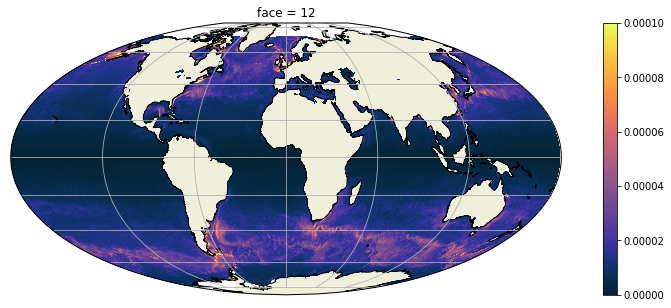

In [8]:
#quick_llc_plot(ds.ugeo_coriolis_linear, vmax=1.e-4, 
#               axis_off=True, add_colorbar=False)
plot_pretty(ds.ugeo_coriolis_linear, vmin=0., vmax=1.e-4, cmmap='thermal', ignore_face=[6])

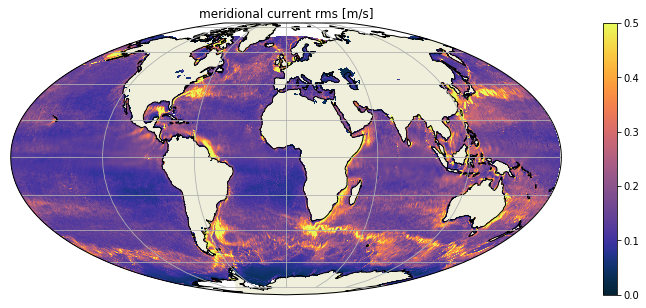

In [15]:
#quick_llc_plot(ds.ugeo_coriolis_linear/np.abs(ds.f), vmax=1.e0, 
#               axis_off=True, add_colorbar=False)
plot_pretty(ds.ugeo_coriolis_linear/np.abs(ds.f), title='meridional current rms [m/s]',
            vmin=0., vmax=.5, cmmap='thermal', ignore_face=[6])

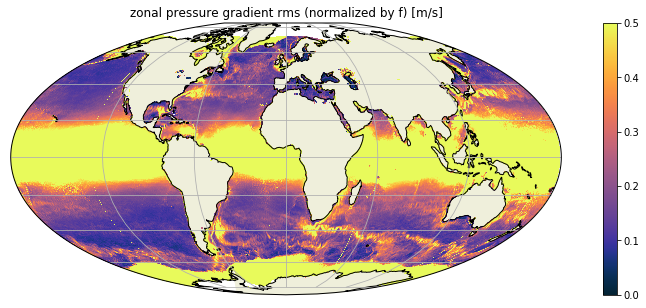

In [16]:
plot_pretty(ds.ugeo_gradp/np.abs(ds.f), title='zonal pressure gradient rms (normalized by f) [m/s]',
            vmin=0., vmax=.5, cmmap='thermal', ignore_face=[6])

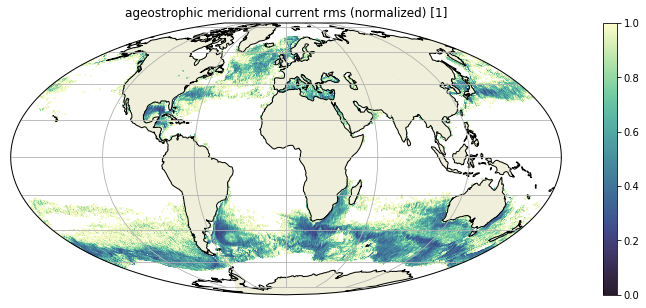

In [17]:
toplt = ds.udiff/ds.ugeo_coriolis_linear
#quick_llc_plot(toplt, vmax=1.e0, 
#               axis_off=True, add_colorbar=False)
toplt = toplt.where(toplt<1.)
plot_pretty(toplt, title='ageostrophic meridional current rms (normalized) [1]',
            vmin=0., vmax=1., cmmap='deep_r', ignore_face=[6])

### meridional momentum balance - zonal flow

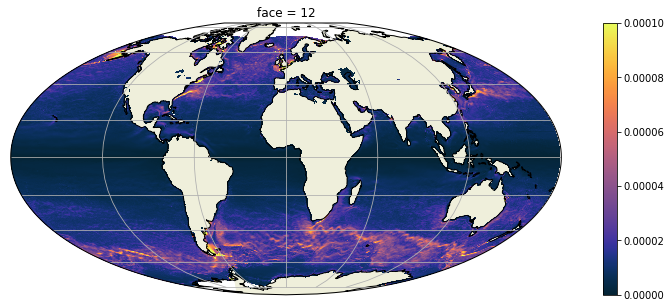

In [6]:
plot_pretty(ds.vgeo_coriolis_linear, vmin=0., vmax=1.e-4, cmmap='thermal', ignore_face=[6])

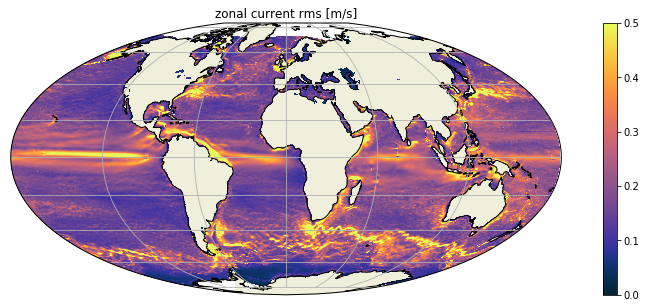

In [7]:
plot_pretty(ds.vgeo_coriolis_linear/np.abs(ds.f), title='zonal current rms [m/s]',
            vmin=0., vmax=.5, cmmap='thermal', ignore_face=[6])

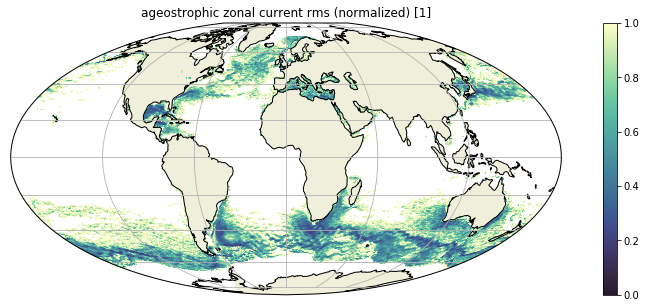

In [8]:
toplt = ds.vdiff/ds.vgeo_coriolis_linear
toplt = toplt.where(toplt<1.)
plot_pretty(toplt, title='ageostrophic zonal current rms (normalized) [1]',
            vmin=0., vmax=1., cmmap='deep_r', ignore_face=[6])

---

## try to compute variances without intermediate storing

to do ...

In [8]:
dxgSSV_j = grid.interp(ds.dxG * ds['SSV'],'Y') 
dxgSSV_ji = grid.interp(dxgSSV_j,'X')    # SSV at (i_g,j)
Coriolis_u_linear = ds.f_j * dxgSSV_ji /ds.dxC    #f*SSV
Coriolis_u_linear = Coriolis_u_linear.rename('Coriolis_u_linear')
Coriolis_u_linear = Coriolis_u_linear.chunk({'i_g':None,'j':None})
# could subsample temporally and spatially here
print(Coriolis_u_linear)
print('Variable size: %.1f GB' %(Coriolis_u_linear.nbytes / 1e9))
# could drop variables here: ['dxC','dyG']
Coriolis_u_linear.to_dataset().to_zarr(
    work_data_dir+'mbal/Coriolis_u_linear_f%02d.zarr'% (face), mode='w')
#var = Coriolis_u_linear.var(dim='time')
#print(var)
#var.plot()
print('face=%d - allready processed'%(face))

<xarray.DataArray 'Coriolis_u_linear' (j: 4320, i_g: 4320, time: 8785)>
dask.array<shape=(4320, 4320, 8785), dtype=float32, chunksize=(4320, 4320, 1)>
Coordinates:
    face     int64 1
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    dxC      (j, i_g) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    dyG      (j, i_g) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
    f_j      (j, i_g) float32 dask.array<shape=(4320, 4320), chunksize=(4320, 4320)>
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 ... 3.732e+07 3.732e+07
Variable size: 655.8 GB
face=1 - allready processed


---

In [17]:
w = cluster.scale_up(30)

In [ ]:
client.restart()

In [9]:
cluster.close()